# Image recognition:

Using keras with theano backend to perform image segmentation, use transfer learning from vgg16 model

In [1]:
%matplotlib inline

In [20]:
#import necesary libraries
import keras
from keras.layers import Dense, Activation, Dropout, Lambda, Flatten
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D, Convolution2D
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils.data_utils import get_file
import os, json
import numpy as np

In [26]:
import utils; reload (utils)
from utils import plots

In [72]:
# import class definitions 
# we download the class definitions from fast.ai
PATH = 'http://files.fast.ai/models/' 
FNAME = 'imagenet_class_index.json'
class_file = get_file(fname = FNAME, origin = PATH+FNAME, cache_subdir = 'models')
with open(class_file) as f: class_dict = json.load(f)
class_list = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [4]:
class_list[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [5]:
# import model weights
FNAME = 'vgg16.h5'
model_weights = get_file(fname = FNAME, origin = PATH+FNAME, cache_subdir = 'models')

In [7]:
# Define the model architecture
def conv_block(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [8]:
def fc_block(model):
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5))

In [11]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

In [16]:
# defining model architecture
def vgg16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape = (3, 224, 224)))
    
    conv_block(2, model, 64)
    conv_block(2, model, 128)
    conv_block(3, model, 256)
    conv_block(3, model, 512)
    conv_block(3, model, 512)
    
    model.add(Flatten())
    fc_block(model)
    fc_block(model)
    model.add(Dense(1000, activation = 'softmax'))
    return model

In [17]:
model = vgg16()

In [19]:
# load precalculated weights to the model
model.load_weights(model_weights)

In [22]:
batch_size = 4

In [33]:
# get predictions from the model
def get_batches(dirname, gen = image.ImageDataGenerator(), batch_size = batch_size, shuffle = True
                , class_mode = 'categorical'):
    return gen.flow_from_directory(directory = dirname, batch_size = batch_size, shuffle = shuffle
                                   , class_mode = class_mode, target_size = (224, 224))

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


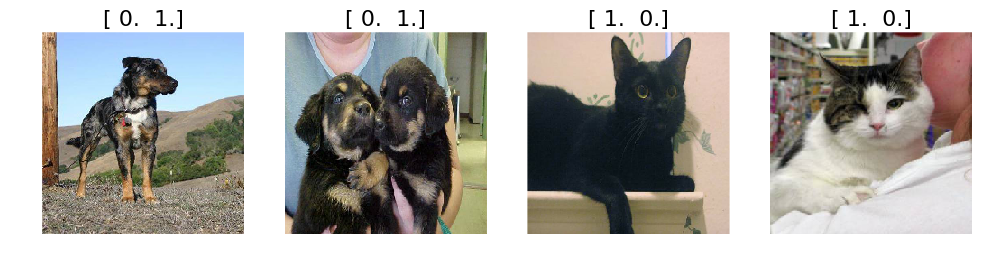

In [34]:
# get batches
batches = get_batches(dirname = '/home/ubuntu/courses/dogscats/sample/train')
val_batches = get_batches(dirname = '/home/ubuntu/courses/dogscats/sample/valid')
img, label = next(batches)

plots(img, titles = label)

In [78]:
# make prediction from our pretrained model
# note that we will get 1000 probabilities for all 1000 classes of ImageNet
def predict_batch(img):
    preds = model.predict(img)
    idx = np.argmax(preds, axis = 1)
    
    # print the first 5 classes probabilities
    print('probabilities for first 5 classes: {0}'.format(preds[0,:5]))
    print('First 5 classes: {0}'.format(class_list[:5]))
    print('Print the most probable class')
    for i in range(len(idx)):
        ci = idx[i]
        print('{0} class is predicted with probability of {1}'.format(class_list[ci], preds[i, ci]))

In [79]:
predict_batch(img)

probabilities for first 5 classes: [  5.7170e-07   1.4019e-06   6.9294e-07   3.4688e-07   4.3611e-07]
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
Print the most probable class
Rottweiler class is predicted with probability of 0.163413926959
Tibetan_mastiff class is predicted with probability of 0.911094367504
Egyptian_cat class is predicted with probability of 0.280232280493
plastic_bag class is predicted with probability of 0.102244652808


## Use finetuning:

In [86]:
#path = '/home/ubuntu/courses/dogscats/'
path = '/home/ubuntu/courses/dogscats/sample/'

In [83]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [84]:
batch_size = 4

In [85]:
# create an object 
vgg = Vgg16()

In [88]:
# get train and validation batches
batches = vgg.get_batches(path+'train', batch_size = batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size = batch_size)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [89]:
# finetune the model
# basically fine tune removes the last layer with 100 outputs and puts in a dense layer with 2 outputs
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch = 1)

Epoch 1/1
16/16 [==============================] - 0s - loss: 0.9729 - acc: 0.6250 - val_loss: 0.9101 - val_acc: 0.7500


### Summary: 
   This is a quick implementation of image recognition. We see that even with a sample set of 100 images per category and one epoch we are able to get pretty good accuracy. We can increase the input size and gain significant performance gains. This process can be followed for any image classificatio problems.

In [90]:
vgg.predict(img)

(array([ 0.5974,  0.997 ,  0.9984,  0.9983], dtype=float32),
 array([0, 1, 0, 0]),
 ['cats', 'dogs', 'cats', 'cats'])

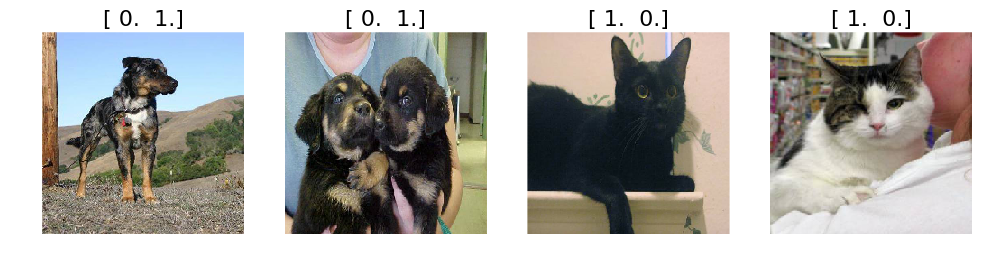

In [91]:
plots(img, titles = label)